In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import scipy

import itertools

import datetime
from functools import reduce
from copy import deepcopy

from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera

from itertools import product
from tqdm import tqdm

from pykalman import KalmanFilter, UnscentedKalmanFilter

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit, TimeSeriesSplit

from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

import xgboost as xgb

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import KFold

from keras.losses import KLDivergence

from keras import backend as K

from keras.optimizers import SGD
from keras.models import *
from keras.layers import *
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from joblib import Parallel, delayed

def get_pif(path):
        df = pd.read_excel(path, sheet_name="Config")
        df = df.fillna("XXXXX")
        return list(df['PIF'])

def STR_TO_DT(df, col_horaire):
    df_temp = df
    l_dt = []
    for t in range(df.shape[0]):
        TSTR =  str(df[col_horaire][t])
        if len(TSTR)<10:
            l = [int(i) for i in TSTR.split(':')]
            l_dt.append(datetime.time(hour=l[0], minute=l[1], second=0))
        else:
            TSTR = TSTR[10:]
            l = [int(i) for i in TSTR.split(':')]
            l_dt.append(datetime.time(hour=l[0], minute=l[1], second=0))
    
    df[col_horaire] = l_dt
    return df_temp
    

def cat_num_col(df):
        
    numerical_col = ['Local Date', 'Horaire théorique', 'Pax LOC TOT', 'Pax CNT TOT', 'PAX TOT']
    categorical_col_bool = ~df.columns.isin(numerical_col)
    categorical_col = []

    for c, i in zip(df.columns, range(len(df.columns))):
        if categorical_col_bool[i] == True:
            categorical_col.append(c)
    categorical_col

    df[categorical_col] = df[categorical_col].astype(str)

    return df

def print_num_vol(df, col_libel, terminaux):
    x = df.loc[(df['A/D'] == 'D') & (df[col_libel].isin(terminaux))]
    s = ""
    for n in pd.unique(x['Num Vol']):
        s += n + ";"

    # to copy/paste for SAPBO request
    print("Vols:")
    print(s)
    print("Nombre de vol sur la période:", len(pd.unique(x['Num Vol'])))
    print()

    txt_file = open('liste_num_vol.txt', 'w')
    txt_file.write(s[:-1])
    txt_file.close()

def polynomial(x, a, b, c, d, e, f):
    # conditions aux limites: on veut 0 pax a t-4h et 0 pax a t
    # alors on sait que quand on évalue le poly en 0 et 25 on a p(0) = 0 et p(25) = 0
    # donc 0 et 25 sont des racines réelles => on peut factoriser par x-0 et x-25

    return x * (x-25) * (a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f)


def kalman_smoothing(y):
    kf = KalmanFilter(transition_matrices=[1],
                    observation_matrices=[1],
                    initial_state_mean=0,
                    initial_state_covariance=1,
                    observation_covariance=1,
                    transition_covariance=1)
    
    kf.em(y)
    smoothed_state_means, _ = kf.smooth(y)
    return smoothed_state_means.flatten()


def get_x_previ_df(path, sheet_name, col_horaire):
    df = pd.read_excel(path, sheet_name)
    df.drop(['Unnamed: 0', 'Affectation', 'Etat du vol'], axis=1, inplace=True)
    df['Porteur'].fillna('MP', inplace=True)
    df['Libellé terminal'] = df['Libellé terminal'].str.replace("T1_Inter","Terminal 1")
    df['Libellé terminal'] = df['Libellé terminal'].str.replace("T1_5","Terminal 1_5")
    df['Libellé terminal'] = df['Libellé terminal'].str.replace("T1_6","Terminal 1_6")
    df['Cie Ope'].dropna(inplace=True)
    df['Num Vol'].dropna(inplace=True)

    numerical_col = ['Local Date', 'Horaire théorique', 'Pax LOC TOT', 'Pax CNT TOT', 'PAX TOT']
    categorical_col = ~df.columns.isin(numerical_col)

    l_date = pd.to_datetime(df['Local Date'].unique().tolist()).date
    l_date = sorted(l_date)

    df_pgrm = STR_TO_DT(df, col_horaire)
    return df_pgrm, l_date


def get_x_rea_df(path_file):
    f = lambda s: datetime.datetime.strptime(s,'%d/%m/%Y')
    x_rea_df = pd.read_csv(path_file, 
                        sep=',', 
                        date_format='%dd/%mm/%YYYY')
    # print(x_rea_df.columns)
    x_rea_df.rename(columns=
                    {"Année":"Year", 
                    "Mois":"month",
                    "Plage Hub":"Plage",
                    "Type porteur":"Porteur",
                    "Code aéroport IATA":"Prov Dest",
                    "Code IATA compagnie":'Cie Ope',
                    "Type de mouvement":"A/D",
                    "Terminal":"Libellé terminal",
                    "Nombre de passagers réalisés":"PAX TOT",
                    "Jour":"Local Date",
                    "Numéro de vol":"Num Vol",
                    "Type de contact":"Contact/Large",
                    "Heure théorique":'Horaire théorique'},
                    inplace=True)

    # x_rea_df['Local Date'] = pd.to_datetime(x_rea_df['Local Date']).dt.date

    x_rea_df['Horaire théorique'] = pd.to_datetime(x_rea_df['Horaire théorique'], format="%H:%M", errors='coerce').dt.time
    x_rea_df[['Pax LOC TOT', 'Pax CNT TOT']] = 0

    x_rea_df['A/D'] = x_rea_df['A/D'].str.replace("Départ","D")
    x_rea_df['A/D'] = x_rea_df['A/D'].str.replace("Arrivée","A")

    # x_rea_df['Contact/large'] = x_rea_df['Contact/Large'].str.replace("au contact","Contact")
    # x_rea_df['Contact/large'] = x_rea_df['Contact/Large'].str.replace("au large","Large")

    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("salle L","T2E-L")

    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("salle K","T2E-K")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("salle L","T2E-L")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("salle M","T2E-M")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("D","T2D")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("B","T2B")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("A","T2A")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("salle M","T2E-M")

    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("Jonction","Terminal 1")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("sat5","Terminal 1_5")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("sat6","Terminal 1_6")

    ind = x_rea_df['Salle corrigée'].loc[x_rea_df['Salle corrigée'].isin(['Terminal 1', 'Terminal 1_5', 'Terminal 1_6'])].index
    x_rea_df['Libellé terminal'].iloc[ind] = x_rea_df['Salle corrigée'].iloc[ind]

    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Lundi","Monday")
    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Mardi","Thuesday")
    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Mercredi","Wednesday")
    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Jeudi","Thursday")
    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Vendredi","Friday")
    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Samedi","Saturday")
    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Dimanche","Sunday")


    x_rea_df['Porteur'] = x_rea_df['Porteur'].str.replace('Gros porteur', "GP")
    x_rea_df['Porteur'] = x_rea_df['Porteur'].str.replace('Moyen porteur', "MP")
    
    try:
        x_rea_df.drop(['Compagnie' ,'Contact/Large'], axis=1, inplace=True)
    except ValueError:
        pass

    x_rea_df = x_rea_df.dropna().reset_index(drop=True)
    x_rea_df = cat_num_col(x_rea_df)


    # ajout des vacances / jours fériés / ponts / grèves
    calendrier_gouv = pd.read_csv(r"calendar_complete_from_data_gouv.csv", sep=',', date_format='%dd/%mm/%YYYY')
    calendrier_gouv['date'] = calendrier_gouv['date'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d").strftime("%d/%m/%Y"))
    calendrier_gouv.fillna('non_ferie', inplace=True)
    x_rea_df = pd.merge(x_rea_df, calendrier_gouv, left_on='Local Date', right_on='date', how='left')
    x_rea_df.drop(columns=['date'], axis=1, inplace=True)

    return x_rea_df


def get_y_df(path_file, shift_days_pax=14, sep=','):
    y_actual_data = pd.read_csv(path_file, sep=sep, date_format='%dd/%mm/%YYYY')
    y_actual_data.columns = ['Source', 'Local Date', 'Plage', 'A/D', 'Cie Ope', 'Num Vol', 'Immatriculation', 'Sous-type avion', 'Ville', 'Prov Dest', 'Faisceau géographique', 'PAX TOT', 'Offre']

    calendrier_gouv = pd.read_csv(r"calendar_complete_from_data_gouv.csv", sep=',', date_format='%dd/%mm/%YYYY')
    calendrier_gouv['date'] = calendrier_gouv['date'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d").strftime("%d/%m/%Y"))
    calendrier_gouv.fillna('non_ferie', inplace=True)
    df = pd.merge(y_actual_data, calendrier_gouv, left_on='Local Date', right_on='date', how='left')
    df.drop(columns=['date'], axis=1, inplace=True)

    # df['PAX TOT'] = df['PAX TOT'].apply(lambda x: x.replace(u'\xa0', u'')).astype(int)
    df['Year'] = pd.to_datetime(df['Local Date'], format="%d/%m/%Y").dt.year
    df['month'] = pd.to_datetime(df['Local Date'], format="%d/%m/%Y").dt.month
    # df['Semaine'] = pd.to_datetime(df['Local Date'], format="%d/%m/%Y").apply(lambda x: x.isocalendar()[1])
    # df['Jour de la semaine'] = pd.to_datetime(df['Local Date'], format="%d/%m/%Y").apply(lambda x: x.isocalendar()[-1])
    
    return df



class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, object_col):
        """Encode the data based on object column provided
        """
        self.object_col = object_col

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        dummy_df = pd.get_dummies(X[self.object_col], drop_first=True)
        X = X.drop(X[self.object_col], axis=1)
        X = pd.concat([dummy_df, X], axis=1)
        return X
    
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, object_cols):
        """Encode the data based on object columns provided using label encoding
        """
        self.object_cols = object_cols
        self.encoders = {}

    def fit(self, X, y=None):
        for col in self.object_cols:
            encoder = LabelEncoder()
            encoder.fit(X[col])
            self.encoders[col] = encoder
        return self

    def transform(self, X, y=None):
        for col, encoder in self.encoders.items():
            X[col] = encoder.transform(X[col])
        return X
    
    def inverse_transform(self, X):
        for col, encoder in self.encoders.items():
            X[col] = encoder.inverse_transform(X[col])
        return X
    
class CustomNumericalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, object_col):
        """Encode the data based on object column provided
        """
        self.object_col = object_col

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        sc = StandardScaler()
        X[self.object_col] = sc.fit_transform(X[self.object_col])
        return X
    
# class CustomTimeEncoder(BaseEstimator, TransformerMixin):
#     def __init__(self, time_col):
#         self.object_col = time_col

#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X, y=None):
#         if self.object_col != 'Local Date':
#             X['sin_time'] = np.sin(2 * np.pi * pd.to_timedelta(X[self.object_col].astype(str)).dt.total_seconds()/86400)
#             X['cos_time'] = np.cos(2 * np.pi * pd.to_timedelta(X[self.object_col].astype(str)).dt.total_seconds()/86400)
#             X = X.drop(self.object_col, axis=1)
#         else:
#             X = X.drop(self.object_col, axis=1)
#         return X
    

class CustomTimeEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, time_col):
        self.object_col = time_col

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.object_col == 'Horaire théorique':
            X['sin_time'] = np.sin(2 * np.pi * pd.to_timedelta(X[self.object_col].astype(str)).dt.total_seconds()/86400)
            X['cos_time'] = np.cos(2 * np.pi * pd.to_timedelta(X[self.object_col].astype(str)).dt.total_seconds()/86400)
            X = X.drop(self.object_col, axis=1)
        if self.object_col == 'Semaine':
            X['semaine_sin_time'] = np.sin(2 * np.pi * X[self.object_col]/52)
            X['semaine_cos_time'] = np.cos(2 * np.pi * X[self.object_col]/52)
            X = X.drop(self.object_col, axis=1)
        if self.object_col == 'month':
            X['month_sin_time'] = np.sin(2 * np.pi * X[self.object_col]/12)
            X['month_cos_time'] = np.cos(2 * np.pi * X[self.object_col]/12)
            X = X.drop(self.object_col, axis=1)
        if self.object_col == 'Local Date':
            X = X.drop(self.object_col, axis=1)
        return X
    
    
class CustomTargetPrevisionEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, y):
        return self
    
    def transform(self, y):
        x = np.linspace(0, 25, 26) # correspond aux pas de 10min entre 0 et 4h
        transformed_y = np.zeros((len(y), 26))
        for i, coeffs in enumerate(y):
            for j, x in enumerate(range(26)):
                res = polynomial(x, *coeffs)
                transformed_y[i, j] = max(res, 0)
            sum = np.sum(transformed_y[i])
            if sum!=0:
                transformed_y[i] /= sum
        return transformed_y
    
class CustomTargetRepartitionEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, target_col):
        self.object_col = target_col
    
    def fit(self, y):
        return self
    
    def transform(self, y):
        y[self.object_col] = y[self.object_col].astype(int)
        y['tot_sum'] = y.loc[:, self.object_col].sum(1)
        for c in self.object_col:
            y[c] /= y['tot_sum']
        
        y.drop('tot_sum', axis=1,inplace=True)
        return y
    


In [3]:
def custom_loss_remplissage(y_true, y_pred):
    #  Mean Absolute Error
    mae = K.mean(K.abs(y_true - y_pred), axis=-1)
    # la somme répartion == 1
    constraint_penalty = K.square(K.sum(y_pred, axis=-1) - 1)
    # la somme remplissage == 1
    total_loss = mae + constraint_penalty

    return total_loss


def kalman_smoothing(y, smoothing_factor=1):
    kf = KalmanFilter(transition_matrices=[1],
                    observation_matrices=[1],
                    initial_state_mean=0,
                    initial_state_covariance=1,
                    observation_covariance=1,
                    transition_covariance=smoothing_factor)
    
    kf.em(y)
    smoothed_state_means, _ = kf.smooth(y)
    return smoothed_state_means.flatten()


def kalman_smoothing_fast(y):
    kf = KalmanFilter()
    Kc, Ke = kf.em(y, n_iter=1).smooth(0)
    return Kc.flatten()

def compute_ma(df, vol, col, window):
    x = df.loc[df['Num Vol'] == vol][col]
    if x.shape[0] > window:
        x = x.rolling(window).mean().bfill()
    elif x.shape[0] > 1:
        x = x.rolling(x.shape[0]-1).mean().bfill()
    return x

def compute_ewm(df, vol, col, window):
    x = df.loc[df['Num Vol'] == vol][col]
    if x.shape[0] > 1:
        x = x.ewm(span=window).mean().bfill()
    return x

def compute_ewm_std(df, vol, col, window):
    x = df.loc[df['Num Vol'] == vol][col]
    if x.shape[0] > 1:
        x = x.ewm(span=window).std().bfill()
    return x

def compute_kalman(df, vol, col):
    x = df.loc[df['Num Vol'] == vol][col]
    if x.shape[0] > 1:
        x = kalman_smoothing(x)
    return x


def compute_kalman_fast(series):
    if series.shape[0] > 1:
        return kalman_smoothing(series)
    

def compute_plot_acf(series, lags=60, diff_order=1):

    # ACF and PACF
    acf_values = acf(series.dropna(), nlags=lags)
    pacf_values = pacf(series.dropna(), nlags=lags)

    # Ljung-Box Test
    res = acorr_ljungbox(series.dropna(), lags=lags)
    lb_stat =  res['lb_stat']
    lb_p_value = res['lb_pvalue']

    # Normality Test
    jb_stat, jb_p_value, _, _ = jarque_bera(series.dropna())

    # Print results of other tests
    print(f"Jarque-Bera Test: Statistic={jb_stat}, p-value={jb_p_value}")

    # Plot ACF and PACF
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.stem(acf_values)
    plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
    plt.axhline(y=-0.05, color='r', linestyle='--', label='Significance Level (-0.05)')
    plt.title('ACF')

    plt.subplot(1, 3, 2)
    plt.stem(pacf_values)
    plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
    plt.axhline(y=-0.05, color='r', linestyle='--', label='Significance Level (-0.05)')
    plt.title('PACF')

    # Plot Ljung-Box Test Results
    plt.subplot(1, 3, 3)
    plt.plot(range(1, lags + 1), lb_p_value, marker='o')
    plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
    plt.title('Ljung-Box Test')
    plt.xlabel('Lag')
    plt.ylabel('P-value')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # First difference
    first_difference = series.dropna().diff(diff_order).dropna()

    # PACF of the first difference
    pacf_values_diff1 = pacf(first_difference, nlags=lags)

    # Plot PACF of the first difference
    plt.stem(pacf_values_diff1)
    plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
    plt.axhline(y=-0.05, color='r', linestyle='--', label='Significance Level (-0.05)')
    plt.title(f'PACF after {diff_order} Difference')
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.show()

In [9]:
path_to_file = r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\pgrm"
file = r"\x_rea_pgrm.csv"

x_rea_df = get_x_rea_df(path_to_file + file)

immat = pd.read_excel(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\pgrm\offre en siège.xlsx", header=0)
x_rea_df = pd.merge(x_rea_df, immat, left_on=['Immatriculation'], right_on=['Immatriculation'], how='left').drop(columns=['Immatriculation', 'Avion'], axis=1)

x_rea_df.sort_values(by=['Num Vol', 'Local Date'], inplace=True)
x_rea_df.reset_index(drop=True, inplace=True)

x_rea_df['Taux Remplissage'] = x_rea_df['PAX TOT'] / x_rea_df['Offre sièges']
# x_rea_df['Taux Remplissage'] = x_rea_df['Taux Remplissage'].dropna().reset_index(drop=True).fillna(0)
x_rea_df.drop(columns=['Offre sièges'], axis=1, inplace=True)
ind = x_rea_df['Taux Remplissage'].loc[x_rea_df.isna().any(axis=1)].index
x_rea_df.loc[ind, 'Taux Remplissage'] = 0


ind = x_rea_df.loc[x_rea_df['Taux Remplissage'] > 1.2].index
x_rea_df.drop(index=ind, inplace=True)
x_rea_df.loc[x_rea_df['Taux Remplissage'] > 1, 'Taux Remplissage'] = 1
x_rea_df.reset_index(drop=True, inplace=True)

liste_greve = ['27/03/2023', '01/05/2023', '02/10/2023']
ind_greve = x_rea_df.loc[x_rea_df['Local Date'].isin(liste_greve)].index

x_rea_df.drop(ind_greve, axis=0, inplace=True)
x_rea_df.reset_index(drop=True, inplace=True)

C:\Users\nazzaren\AppData\Local\Temp\ipykernel_18684\3666354419.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_rea_df['Libellé terminal'].iloc[ind] = x_rea_df['Salle corrigée'].iloc[ind]


In [ ]:
shift_days_pax = 14 # horizons de prédictions

x_rea_df['PAX TOT SHIFT'] = x_rea_df['PAX TOT']
x_rea_df['Taux Remplissage SHIFT'] = x_rea_df['Taux Remplissage']
x_rea_df['Taux Remplissage diff'] = x_rea_df['Taux Remplissage']
for num_vol in tqdm(x_rea_df['Num Vol'].unique()):
    x_rea_df.loc[x_rea_df['Num Vol'] == num_vol, 'PAX TOT SHIFT'] = x_rea_df.loc[x_rea_df['Num Vol'] == num_vol, 'PAX TOT'].shift(shift_days_pax)
    x_rea_df.loc[x_rea_df['Num Vol'] == num_vol, 'Taux Remplissage SHIFT'] = x_rea_df.loc[x_rea_df['Num Vol'] == num_vol, 'Taux Remplissage'].shift(shift_days_pax)
    x_rea_df.loc[x_rea_df['Num Vol'] == num_vol, 'Taux Remplissage diff'] = x_rea_df.loc[x_rea_df['Num Vol'] == num_vol, 'Taux Remplissage'].diff(1)
x_rea_df.dropna(inplace=True)
x_rea_df.drop(columns=['PAX TOT', 'Pax LOC TOT', 'Pax CNT TOT', 'Salle corrigée'], axis=1, inplace=True)

x_rea_df.to_csv(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\pgrm\repartition_sauvegarde\x_rea_pgrm.csv", index=False)

In [ ]:
x_rea_df = pd.read_csv(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\pgrm\repartition_sauvegarde\x_rea_pgrm.csv")
x_rea_df.head()

Begin grouping Taux Remplissage by Num Vol, month and day of the week...
End grouping Taux Remplissage by Num Vol, month and day of the week


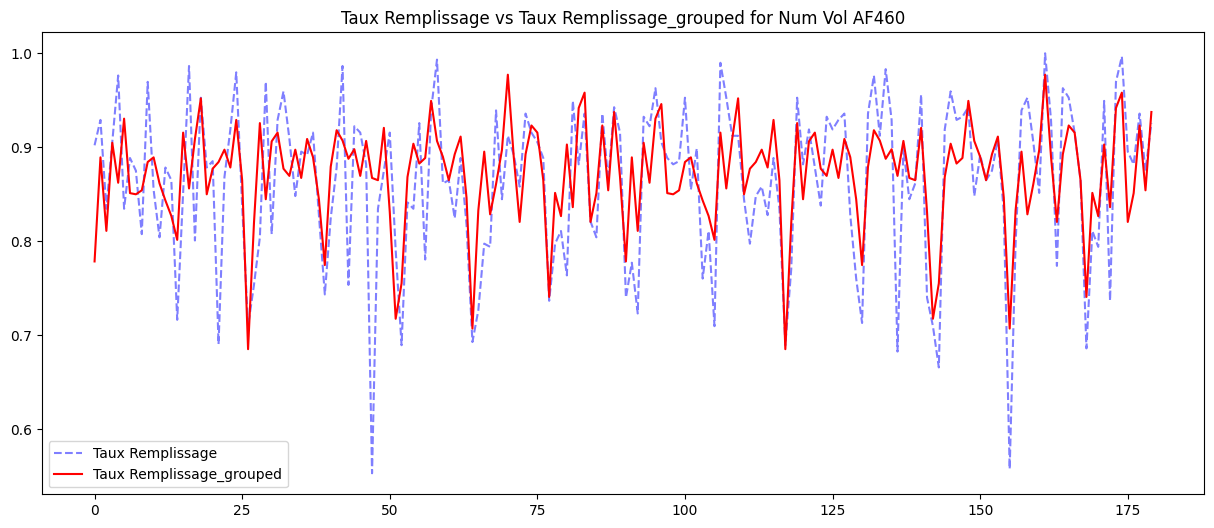

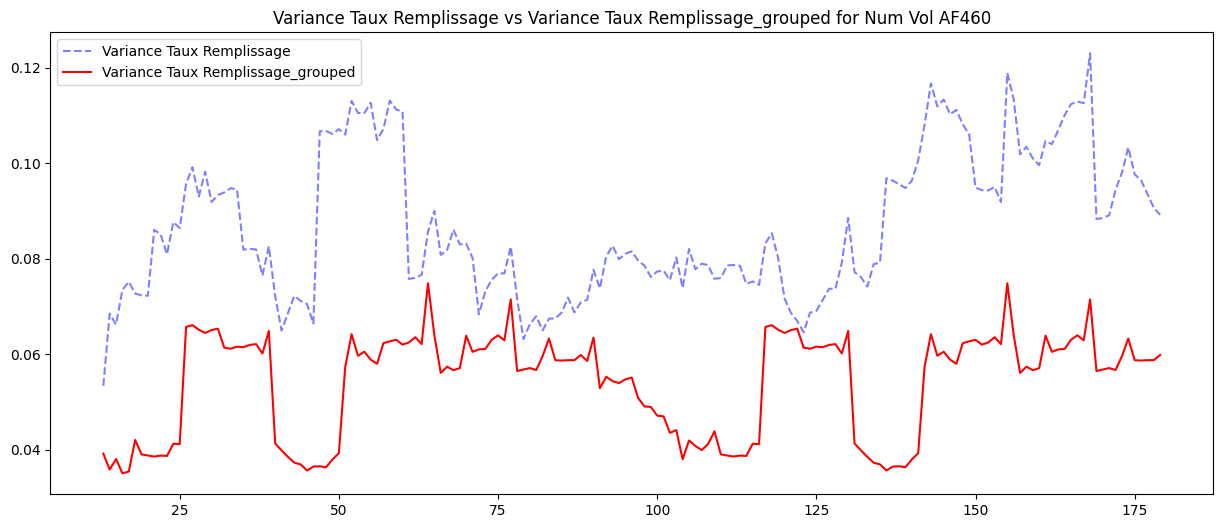

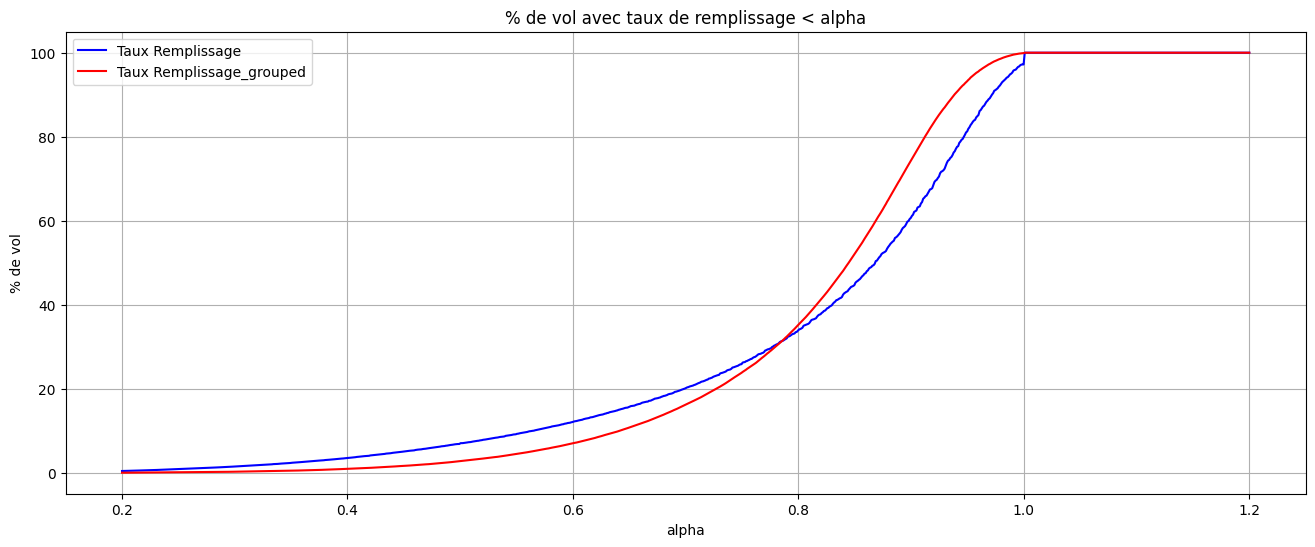

Replacing Taux Remplissage by Taux Remplissage_grouped and dropping Taux Remplissage_grouped
All operations completed


In [13]:
# COMPUTE MEAN OF Taux Remplissage for each Num Vol and each month and each day of the week

print("Begin grouping Taux Remplissage by Num Vol, month and day of the week...")
x_rea_grouped = x_rea_df.groupby(by=['Num Vol', 'month', 'Jour de la semaine'])['Taux Remplissage'].apply(lambda x: np.mean(x)).reset_index()
x_rea_processed = x_rea_df.merge(x_rea_grouped, on=['Num Vol', 'month', 'Jour de la semaine'], how='left', suffixes=('', '_grouped'))

print("End grouping Taux Remplissage by Num Vol, month and day of the week")

# Example of Taux Remplissage vs Taux Remplissage_grouped for a specific Num Vol
plt.figure(figsize=(15, 6))
plt.plot(x_rea_processed.loc[x_rea_processed['Num Vol'] == 'AF460']['Taux Remplissage'].values[:180], label='Taux Remplissage', color='blue', alpha=0.5, linestyle='--')
plt.plot(x_rea_processed.loc[x_rea_processed['Num Vol'] == 'AF460']['Taux Remplissage_grouped'].values[:180], label='Taux Remplissage_grouped', color='red', alpha=1)
plt.legend()
plt.title("Taux Remplissage vs Taux Remplissage_grouped for Num Vol AF460")
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(x_rea_processed.loc[x_rea_processed['Num Vol'] == 'AF460']['Taux Remplissage'][:180].rolling(14).std().values, label='Variance Taux Remplissage', color='blue', alpha=0.5, linestyle='--')
plt.plot(x_rea_processed.loc[x_rea_processed['Num Vol'] == 'AF460']['Taux Remplissage_grouped'][:180].rolling(14).std().values, label='Variance Taux Remplissage_grouped', color='red', alpha=1)
plt.legend()
plt.title("Variance Taux Remplissage vs Variance Taux Remplissage_grouped for Num Vol AF460")
plt.show()


plt.figure(figsize=(16, 6))
plt.plot(np.linspace(0.2, 1.2, 1000), [x_rea_processed.loc[x_rea_processed['Taux Remplissage'] < alpha, 'Taux Remplissage'].shape[0]/x_rea_processed.shape[0] * 100 for alpha in np.linspace(0.2, 1.2, 1000)], color='blue', label='Taux Remplissage')
plt.plot(np.linspace(0.2, 1.2, 1000), [x_rea_processed.loc[x_rea_processed['Taux Remplissage_grouped'] < alpha, 'Taux Remplissage_grouped'].shape[0]/x_rea_processed.shape[0] * 100 for alpha in np.linspace(0.2, 1.2, 1000)], color='red', label='Taux Remplissage_grouped')
plt.xlabel('alpha')
plt.ylabel('% de vol') 
plt.legend()
plt.title('% de vol avec taux de remplissage < alpha')
plt.grid()
plt.show()


print("Replacing Taux Remplissage by Taux Remplissage_grouped and dropping Taux Remplissage_grouped")
x_rea_processed['Taux Remplissage'] = x_rea_processed['Taux Remplissage_grouped']
x_rea_processed.drop(columns=['Taux Remplissage_grouped'], axis=1, inplace=True)
print("All operations completed")

x_rea_df = deepcopy(x_rea_processed)

In [1]:
# def plot_pax_cnt_smoothing(data, vol, col_plot, window, smoothing_type):
#     plt.figure(figsize=(15, 7))
#     plt.plot(data.loc[data['Num Vol'] == vol][col_plot].values, label='unsmoothed (raw) data', alpha=0.3)
#     for smoothing in smoothing_type:
#         if 'ewm' in smoothing:
#             plt.plot(data.loc[data['Num Vol'] == vol][col_plot].ewm(span=window).mean().values, label=f'exponential weighted moving average (span={window})', linestyle='-.')
#         elif 'rolling' in smoothing:
#             plt.plot(data.loc[data['Num Vol'] == vol][col_plot].rolling(window=window).mean().values, label=f'smoothed data (window={window})', linestyle='--')
#         elif 'kalman' in smoothing:
#             plt.plot(kalman_smoothing(data.loc[data['Num Vol'] == vol][col_plot].values), label='kalman smoothing', linestyle=':')
#     plt.title(f"{col_plot} PAX fills for all '{vol}' flights  (window={window})")
#     plt.xlabel('Days')
#     plt.ylabel('PAX fills for flight')
#     plt.legend()
#     plt.show()
    

# window = 14
# plot_pax_cnt_smoothing(x_rea_df.loc[(x_rea_df['Taux Remplissage'] >= 0.2) & (x_rea_df['Taux Remplissage'] <= 1.2)], 'AF460', 'Taux Remplissage', window, ['ewm', 'rolling', 'kalman'])


In [2]:
# def test_stationarity(timeseries):
#     #Perform Dickey-Fuller test:
#     print('Results of Dickey-Fuller Test:')
#     dftest = adfuller(timeseries, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print(dfoutput)

# test_stationarity(x_rea_df.loc[x_rea_df['Num Vol'] == 'AF460', 'Taux Remplissage'].dropna())

# # Assuming 'original_series' is your original time series


# compute_plot_acf(x_rea_df.loc[x_rea_df['Num Vol'] == 'AF460', 'Taux Remplissage'], lags=28, diff_order=1)

In [4]:
def preprocessing_NN(data, label_col, numerical_col, target_col, shuffle, stratified_col=None, test_size=0.5):
    preprocessing_pipe_NN = Pipeline(
        steps=[
            ('label_encoder', CustomLabelEncoder(label_col)),
            ('time_encoder_horaire', CustomTimeEncoder('Horaire théorique')),
            ('time_encoder_semaine', CustomTimeEncoder('Semaine')),
            ('time_encoder_month', CustomTimeEncoder('month')),
            ('date_droping', CustomTimeEncoder('Local Date')),
        ]
    )

    data = data.sort_values(by=['Num Vol', 'Local Date']).reset_index(drop=True)
    
    if stratified_col:
        print('Chose stratified split so shuffle=True')
        X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=target_col, axis=1), data[target_col], shuffle=True, test_size=test_size, stratify=stratified_col)
    else:
        print(f'Chose random split and shuffle={shuffle}')
        X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=target_col, axis=1), data[target_col], shuffle=shuffle, test_size=test_size)

    X_train_encoded = preprocessing_pipe_NN.fit_transform(X_train).astype('float64')
    y_train_encoded = y_train.astype('float64')

    y_train_encoded.drop(index=X_train_encoded.loc[X_train_encoded.isna().any(axis=1)].index, inplace=True)
    X_train_encoded.drop(index=X_train_encoded.loc[X_train_encoded.isna().any(axis=1)].index, inplace=True)

    X_test_encoded = preprocessing_pipe_NN.fit_transform(X_test).astype('float64')
    y_test_encoded = y_test.astype('float64')

    y_test_encoded.drop(index=X_test_encoded.loc[X_test_encoded.isna().any(axis=1)].index, inplace=True)
    X_test_encoded.drop(index=X_test_encoded.loc[X_test_encoded.isna().any(axis=1)].index, inplace=True)
    
    return X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded, preprocessing_pipe_NN


def bin_y_series(serie, col, pt_bin):
    return pd.DataFrame(pd.cut(serie[col], bins=np.arange(0.0, 1.2, pt_bin), include_lowest=True, labels=False) * pt_bin, columns=[col], index=serie.index)

In [5]:
def remove_least_classes(x, class_name, threshold=28):
    class_to_stratify = class_name
    least_populated_class = x[class_to_stratify].value_counts().loc[x[class_to_stratify].value_counts() < threshold].index.tolist()

    x = x.loc[~x[class_to_stratify].isin(least_populated_class)].reset_index(drop=True)
    x = x.sort_values(by=['Num Vol', 'Local Date']).reset_index(drop=True)

    x_rea_test = x.loc[x['Year'] == 2023]
    x_rea_train = x.loc[x['Year'] == 2022]

    return x_rea_train, x_rea_test

In [17]:
class_to_stratify = 'Num Vol'
x_rea_train, x_rea_test = remove_least_classes(x_rea_df, class_name=class_to_stratify, threshold=28) # threshold=28 because we want to keep at least 2 weeks of data for each flight for ML

print(f"2022 shape: {x_rea_train.shape}")
print(f"2023 shape: {x_rea_test.shape}")

x_rea_train = pd.concat([x_rea_train, x_rea_test], axis=0).reset_index(drop=True)

Train shape: (334500, 28)
Test shape: (340157, 28)


In [6]:
def process_data_for_lstm(x_rea, label_col, numerical_col, target_col, shuffle, stratified_col=None, test_size=0.5, predicting_mode=False):
    X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded, preprocessing_pipe_NN = preprocessing_NN(data=x_rea,
                                                                                                label_col=label_col, 
                                                                                                numerical_col=numerical_col,
                                                                                                target_col=target_col, 
                                                                                                shuffle=False)
    
    X_train_encoded.drop(columns=['Taux Remplissage diff'], axis=1, inplace=True)
    X_test_encoded.drop(columns=['Taux Remplissage diff'], axis=1, inplace=True)
    data_train = pd.concat([X_train_encoded.reset_index(drop=True), pd.concat([X_train_encoded, y_train_encoded], axis=1).groupby('Num Vol').apply(lambda x: bin_y_series(x, 'Taux Remplissage', 0.01)).reset_index(drop=True)], axis=1)
    data_train = data_train.sort_values(by=['Num Vol', 'Year']).reset_index(drop=True)

    data_test = pd.concat([X_test_encoded, pd.concat([X_test_encoded, y_test_encoded], axis=1).groupby('Num Vol').apply(lambda x: bin_y_series(x, 'Taux Remplissage', 0.01)).reset_index(drop=True).set_index(X_test_encoded.index)], axis=1)
    # data_test = data_test.sort_values(by=['Num Vol', 'Local Date']).reset_index(drop=True)
    data_test = data_test.sort_values(by=['Num Vol', 'Year']).reset_index(drop=True).set_index(X_test_encoded.index)

    
    data = pd.concat([data_train, data_test], axis=0).sort_values(by=['Num Vol', 'Year']).reset_index(drop=True)

    vol_max_length_data = max([len(data.loc[data['Num Vol'] == vol]) for vol in tqdm(data['Num Vol'].unique())])
    vol_max_length_name_data = [vol for vol in tqdm(data['Num Vol'].unique()) if len(data.loc[data['Num Vol'] == vol]) == vol_max_length_data][0]

    print(f"vol_max_length_data: {vol_max_length_data} for flight labeled : {vol_max_length_name_data}")
    print()

    return data, vol_max_length_name_data, preprocessing_pipe_NN



In [36]:
# ###### LSTM MODEL INPUTS ######

# def create_sequences(data, sequence_length, target_cols):
#     X_seq, y_seq = [], []

#     for i in range(len(data) - sequence_length):
#         x_features = data.iloc[i:i+sequence_length].drop(columns=target_cols, axis=1).values

#         current_targets = data.iloc[i+sequence_length][target_cols].values

#         x_seq = np.column_stack((x_features, np.tile(current_targets, (len(x_features), 1))))

#         y_seq.append(current_targets)

#         X_seq.append(x_seq)

#     return np.array(X_seq), np.array(y_seq)

# def create_sequences_prediction(data, sequence_length, target_cols):
#     """Create sequences for prediction without target variable"""
#     X_seq = []
#     for i in range(len(data) - sequence_length):
#         x_features = data.iloc[i:i+sequence_length].drop(columns=target_cols, axis=1).values
#         current_targets = data.iloc[i+sequence_length][target_cols].values
#         x_seq = np.column_stack((x_features, np.tile(current_targets, (len(x_features), 1))))
#         X_seq.append(x_seq)
#     return np.array(X_seq)

# # WITHOUT TARGET VARIABLE IN THE SEQUENCES FOR X

# def create_sequences_without_target_cols(data, sequence_length, target_cols):
#     X_seq, y_seq = [], []
#     if len(target_cols) == 1:
#         for i in range(len(data) - sequence_length):
#             x_features = data.iloc[i:i+sequence_length].drop(columns=target_cols, axis=1).values
#             current_targets = data.iloc[i+sequence_length][target_cols]

#             X_seq.append(x_features)
#             y_seq.append(current_targets)
#     else:
#         for i in range(len(data) - sequence_length):
#             x_features = data.iloc[i:i+sequence_length].drop(columns=target_cols, axis=1).values
#             current_targets = data.iloc[i+sequence_length][target_cols]

#             X_seq.append(x_features)
#             y_seq.append(current_targets)

#     return np.array(X_seq), np.array(y_seq)


# def create_sequences_without_target(data, sequence_length):
#     X_seq = []
#     for i in range(len(data) - sequence_length):
#         # Extract the input features (excluding the target variable)
#         x_features = data.iloc[i:i+sequence_length].values
#         X_seq.append(x_features)
#     return np.array(X_seq)

In [23]:
col_unique_id_group = ['Local Date', 'Cie Ope', 'Prov Dest', 'Plage']

print("Train dataset")
print(f"Begin grouping Taux Remplissage by {col_unique_id_group}...")

x_grouped = x_rea_train.groupby(by=col_unique_id_group)['Taux Remplissage'].apply(lambda x: np.mean(x)).reset_index()
x_rea_train_grouped_cie_country = x_rea_train.merge(x_grouped, on=col_unique_id_group, how='left', suffixes=('', '_grouped'))

x_rea_train_grouped_cie_country['Taux Remplissage'] = x_rea_train_grouped_cie_country['Taux Remplissage_grouped']
x_rea_train_grouped_cie_country.drop(columns=['Taux Remplissage_grouped'], axis=1, inplace=True)

# x_rea_train_grouped_cie_country['id'] = x_rea_train_grouped_cie_country[col_unique_id_group[-2]] + x_rea_train_grouped_cie_country[col_unique_id_group[-1]]

x_rea_train_grouped_cie_country['id'] = x_rea_train_grouped_cie_country[col_unique_id_group[-1]]
x_rea_train_grouped_cie_country['id'] = np.add.reduce(x_rea_train_grouped_cie_country[col_unique_id_group[1:]].astype(str), axis=1)


x_rea_train_grouped_cie_country = x_rea_train_grouped_cie_country.sort_values(by=['id', col_unique_id_group[0]]).reset_index(drop=True)

print(f"Done grouping Taux Remplissage by {col_unique_id_group}...")


# print("\nTest dataset")
# print(f"Begin grouping Taux Remplissage by {col_unique_id_group}...")

# x_grouped = x_rea_test.groupby(by=col_unique_id_group)['Taux Remplissage'].apply(lambda x: np.mean(x)).reset_index()
# x_rea_test_grouped_cie_country = x_rea_test.merge(x_grouped, on=col_unique_id_group, how='left', suffixes=('', '_grouped'))

# x_rea_test_grouped_cie_country['Taux Remplissage'] = x_rea_test_grouped_cie_country['Taux Remplissage_grouped']
# x_rea_test_grouped_cie_country.drop(columns=['Taux Remplissage_grouped'], axis=1, inplace=True)

# x_rea_test_grouped_cie_country['id'] = x_rea_test_grouped_cie_country[col_unique_id_group[-1]]
# x_rea_test_grouped_cie_country['id'] = np.add.reduce(x_rea_test_grouped_cie_country[col_unique_id_group[1:]].astype(str), axis=1)

# print(f"Done grouping Taux Remplissage by {col_unique_id_group}...")

Train dataset
Begin grouping Taux Remplissage by ['Local Date', 'Cie Ope', 'Prov Dest', 'Plage']...
Done grouping Taux Remplissage by ['Local Date', 'Cie Ope', 'Prov Dest', 'Plage']...

Test dataset
Begin grouping Taux Remplissage by ['Local Date', 'Cie Ope', 'Prov Dest', 'Plage']...
Done grouping Taux Remplissage by ['Local Date', 'Cie Ope', 'Prov Dest', 'Plage']...


In [3]:
label_col = ['Year', 'month', 'Semaine', 'Local Date', 'Jour de la semaine', 'Plage',
            'A/D', 'Libellé terminal', 'Cie Ope', 'Num Vol',
            'Faisceau géographique', 'Pays', 'Prov Dest', 'Porteur',
            'Sous-type avion', 'is_ferie', 'nom_jour_ferie', 'Zone A', 'Zone B',
            'Zone C', 'Zone A vacance', 'Zone B vacance', 'Zone C vacance', 
            'id']

numerical_col = ['PAX TOT SHIFT', 'Taux Remplissage', 'Taux Remplissage diff', 'Taux Remplissage SHIFT']

target_col = 'Taux Remplissage'
# target_col = ['Taux Remplissage diff']


data_train, vol_max_length_name_data_train, preprocessing_NN_train = process_data_for_lstm(x_rea_train_grouped_cie_country, 
                                                                   label_col, numerical_col, [target_col], 
                                                                   shuffle=False, stratified_col=class_to_stratify, 
                                                                   test_size=0.2)
# data_test, vol_max_length_name_data_test, preprocessing_NN_test = process_data_for_lstm(x_rea_test_grouped_cie_country, 
#                                                                  label_col, numerical_col, [target_col], 
#                                                                  shuffle=False, stratified_col=class_to_stratify, test_size=0.2)


In [35]:
# test = pd.read_csv(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\Machine_Learn_datamart_taux_remplissage2024-04-04-09-12-57.txt", sep="\t")
# test.columns
# # test = get_y_df(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\Machine_Learn_datamart_taux_remplissage2024-04-03-16-04-15.csv", 14, ";")

In [4]:
# shift_days_pax = 14
# col_unique_id_group = ['Local Date', 'Cie Ope', 'Prov Dest', 'Plage']

# y_actual_data = get_y_df(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\Machine_Learn_datamart_taux_remplissage2024-04-08-10-01-50.txt", 14, "\t")
# try:
#     y_actual_data['PAX TOT'].replace(" ", "", regex=True, inplace=True)
#     y_actual_data['PAX TOT'] = y_actual_data['PAX TOT'].apply(lambda x: x.replace(u'\xa0', u''))
# except AttributeError:
#     pass
# y_actual_data['PAX TOT'] = y_actual_data['PAX TOT'].astype(float)

# # y_actual_data[['PAX TOT', 'Offre']] = y_actual_data[['PAX TOT', 'Offre']].astype(int)
# ind = y_actual_data.loc[(y_actual_data['Immatriculation'].isna()) & (y_actual_data['Source'] == "SARIAE")].index
# y_actual_data.drop(index=ind, inplace=True)
# ind = y_actual_data.loc[y_actual_data['Source'].isna()].index
# y_actual_data.drop(index=ind, inplace=True)


# immat = pd.read_excel(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\code\Base immat.xlsx", header=0)

# # immat = pd.read_excel(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\pgrm\offre en siège.xlsx", header=0)
# y_actual_data_merged = pd.merge(y_actual_data, immat, left_on=['Immatriculation'], right_on=['Immatriculation'], how='left').drop(columns=['Immatriculation', 'Avion'], axis=1)
# ind = y_actual_data_merged.loc[(y_actual_data_merged['Source'] == "SARIAE") & (y_actual_data_merged['Offre sièges'].isna())].index
# y_actual_data_merged.drop(index=ind, inplace=True)


# y_actual_data_merged['Taux Remplissage'] = y_actual_data_merged['PAX TOT'] / y_actual_data_merged['Offre sièges']
# y_actual_data_merged['Offre'] = y_actual_data_merged['Offre sièges'] ######### REMPLACER OFFRE par OFFRE SIEGES
# y_actual_data_merged.drop(columns=['Offre sièges'], axis=1, inplace=True) 
# ind = y_actual_data_merged['PAX TOT'].loc[y_actual_data_merged['PAX TOT'] > 600].index
# y_actual_data_merged.drop(index=ind, inplace=True)
# ind = y_actual_data_merged['Taux Remplissage'].loc[y_actual_data_merged['Taux Remplissage'] > 1.2].index
# y_actual_data_merged.drop(index=ind, inplace=True)

# y_actual_data_merged['Semaine'] = pd.to_datetime(y_actual_data_merged['Local Date'], format="%d/%m/%Y").apply(lambda x: x.isocalendar()[1])
# y_actual_data_merged['Jour de la semaine'] = pd.to_datetime(y_actual_data_merged['Local Date'], format="%d/%m/%Y").apply(lambda x: x.isocalendar()[-1])

# list_col = ['PAX TOT', 'Taux Remplissage']


# print(f"Shifting data ({shift_days_pax} days)...")
# for num in tqdm(y_actual_data_merged['Num Vol'].unique()):
#     for c in list_col:
#         y_actual_data_merged.loc[y_actual_data_merged['Num Vol'] == num, f'{c} SHIFT'] = y_actual_data_merged.loc[y_actual_data_merged['Num Vol'] == num, c].shift(shift_days_pax)
# for c in list_col:
#     y_actual_data_merged.drop(index=y_actual_data_merged.loc[y_actual_data_merged[f'{c} SHIFT'].isna()].index, inplace=True)
# print("Data shifted.")

# print("Begin grouping Taux Remplissage by Num Vol, month and day of the week...")
# y_grouped = y_actual_data_merged.loc[(y_actual_data_merged['Source'] == "SARIAE")].groupby(by=col_unique_id_group)['Taux Remplissage']

# y_grouped = y_grouped.mean().reset_index()
# y_actual_data_grouped = y_actual_data_merged.loc[(y_actual_data_merged['Source'] == "SARIAE")].merge(y_grouped, on=col_unique_id_group, how='left', suffixes=('', '_grouped'))
# y_actual_data_grouped['id'] = y_actual_data_grouped[col_unique_id_group[-1]]
# y_actual_data_grouped['id'] = np.add.reduce(y_actual_data_grouped[col_unique_id_group[1:]].astype(str), axis=1)

# print("End grouping Taux Remplissage by Num Vol, month and day of the week")

# # Example of Taux Remplissage vs Taux Remplissage_grouped for a specific Num Vol
# plt.figure(figsize=(15, 6))
# plt.plot(y_actual_data_grouped.loc[y_actual_data_grouped['Num Vol'] == 'A3615']['Taux Remplissage'].values, label='Taux Remplissage', color='blue', alpha=0.5, linestyle='--')
# plt.plot(y_actual_data_grouped.loc[y_actual_data_grouped['Num Vol'] == 'A3615']['Taux Remplissage_grouped'].values, label='Taux Remplissage_grouped', color='red', alpha=1)
# plt.legend()
# plt.show()

# print("Replacing Taux Remplissage by Taux Remplissage_grouped and dropping Taux Remplissage_grouped")
# y_actual_data_grouped['Taux Remplissage'] = y_actual_data_grouped['Taux Remplissage_grouped']
# y_actual_data_grouped.drop(columns=['Taux Remplissage_grouped'], axis=1, inplace=True)
# print("All operations completed")

# y_actual_df = pd.concat([y_actual_data_grouped, y_actual_data_merged.loc[(y_actual_data_merged['Source'] == "SARIAP")]], axis=0).reset_index(drop=True)

# y_actual_df.to_csv(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\code\remplissage\y_actual_df.csv", index=False)

# col_test_label = ['Jour de la semaine', 'Plage', 'A/D', 'Cie Ope', 'Num Vol', 'Prov Dest', 'Ville',  'Sous-type avion',
#                  'Faisceau géographique', 'Zone A', 'Zone B', 'Zone C', 'Zone A vacance', 'Zone B vacance', 'Zone C vacance', 
#                  'Year', 'is_ferie', 'nom_jour_ferie', 'id', 'month', 'Semaine', 'PAX TOT SHIFT']

# labels = col_test_label[:-1]
# preprocessing_pipe_NN_actual_data = Pipeline(
#         steps=[
#             ('label_encoder', CustomLabelEncoder(labels)),
#             # ('time_encoder_horaire', CustomTimeEncoder('Horaire théorique')),
#             ('time_encoder_semaine', CustomTimeEncoder('Semaine')),
#             ('time_encoder_month', CustomTimeEncoder('month'))
#             # ('date_droping', CustomTimeEncoder('Local Date')),
#         ]
#     )

# y_processed_data = preprocessing_pipe_NN_actual_data.fit_transform(y_actual_df)

# classes_y_id = preprocessing_pipe_NN_actual_data.named_steps['label_encoder'].encoders['id'].classes_
# classes_y_num_vol = preprocessing_pipe_NN_actual_data.named_steps['label_encoder'].encoders['Num Vol'].classes_

# label_map_y_num_vol = {i: label for i, label in enumerate(classes_y_num_vol)}
# label_map_y_id = {i: label for i, label in enumerate(classes_y_id)}


# y_processed_data['Num Vol'] = y_processed_data['Num Vol'].map(label_map_y_num_vol)
# y_processed_data['id'] = y_processed_data['id'].map(label_map_y_id)

In [5]:
# for num in tqdm(y_processed_data['Num Vol'].unique()):
#     if y_processed_data.loc[(y_processed_data['Num Vol'] == num) & (y_processed_data['Source'] == "SARIAE") & (y_processed_data['Offre'].isna())].shape[0] > 0:
#         print(f"Num Vol {num} has missing values")

In [6]:
# plt.figure(figsize=(18, 7))
# plt.subplot(2, 1, 1)
# plt.plot(y_processed_data.loc[(y_processed_data['Num Vol'] == 'AF460') & (y_processed_data['Source'] == "SARIAE")]['Taux Remplissage'].values, label='Taux Remplissage', alpha=0.5)
# plt.plot(y_processed_data.loc[(y_processed_data['Num Vol'] == 'AF460') & (y_processed_data['Source'] == "SARIAE")]['Taux Remplissage SHIFT'].values, label='Taux Remplissage SHIFT', alpha=1)
# plt.legend()
# plt.ylabel('Taux Remplissage')
# plt.title("Taux Remplissage vs Taux Remplissage SHIFT for Num Vol AF460")

# plt.subplot(2, 1, 2)
# plt.plot((y_processed_data.loc[(y_processed_data['Num Vol'] == 'AF460') & (y_processed_data['Source'] == "SARIAE")]['Taux Remplissage'] - y_processed_data.loc[(y_processed_data['Num Vol'] == 'AF460') & (y_processed_data['Source'] == "SARIAE")]['Taux Remplissage SHIFT']).values, color="violet", label='Delta', alpha=1)
# plt.hlines(y=0, xmin=0, xmax=y_processed_data.loc[(y_processed_data['Num Vol'] == 'AF460') & (y_processed_data['Source'] == "SARIAE")].shape[0], color='gray', linestyle='--')
# plt.legend()
# plt.xlabel('Days')
# plt.ylabel('Delta Taux Remplissage')
# plt.title("Delta Taux Remplissage vs Taux Remplissage SHIFT for Num Vol AF460")
# plt.show()


In [13]:
def make_predictions(model, X_seq_test, y_seq_test=None):
    pred = model.predict(X_seq_test)
    y = pd.DataFrame(pred, columns=['pred'])
    if y_seq_test is not None:
        y['actual'] = y_seq_test
        y['delta'] = y['actual'] - y['pred']
    return y

In [14]:
def process_round_for_NN(data, col_dict):
    data_copy = deepcopy(data)
    for col, v in col_dict.items():
        data_copy[col] = np.round(data[col]/v)*v
    return data_copy


def UKS(y, smoothing_factor=50):
    ukf = UnscentedKalmanFilter(observation_covariance=smoothing_factor)
    (filtered_state_means, _) = ukf.filter(y)
    return filtered_state_means


def process_data_for_NN(df, retained_columns):
    unique_flight_data = deepcopy(df)
    return unique_flight_data[retained_columns]

def process_normalization_for_NN(df, sequence_length, col_to_normalize):
    unique_flight_data = deepcopy(df)
    for col, d in col_to_normalize.items():
        unique_flight_data[f"{col} NORM"] = ((unique_flight_data[col] - unique_flight_data[col].rolling(window=sequence_length).mean())/unique_flight_data[col].rolling(window=sequence_length).std())
        unique_flight_data[f"{col} STD"] = unique_flight_data[col].rolling(window=sequence_length).std()
        if d:
            unique_flight_data.drop(columns=col, axis=1, inplace=True)
    unique_flight_data.dropna(inplace=True)
    return unique_flight_data


def process_trigo_for_NN(df, col_to_trigo):
    unique_flight_data = deepcopy(df)
    for col in col_to_trigo:
        unique_flight_data[f"{col} sin"] = np.sin(unique_flight_data[col])
        unique_flight_data[f"{col} cos"] = np.cos(unique_flight_data[col])
        # unique_flight_data.drop(columns=col, axis=1, inplace=True)
    return unique_flight_data


In [15]:
def get_data_xgboost(data, col_test_pred, col_to_drop, target_col, target_shift, window_ma, window, sequence_length, secondary_target_col, is_target_kalman=False):
    """ 
    Get data for xgboost model with target_col as target variable and secondary_target_col as target variable to predict 
    with a window of window days and a sequence_length of sequence_length days for each flight in data. 

    Inputs:
    data: pd.DataFrame
    col_test_pred: list
    col_to_drop: list
    target_col: str
    target_shift: str
    window: int
    sequence_length: int
    secondary_target_col: str
    is_target_kalman: bool

    Returns:
    pd.DataFrame
    """

    subset = deepcopy(data)
    tr = process_data_for_NN(subset, col_test_pred + [target_col, target_shift])
    if is_target_kalman:
        tr['Taux Remplissage'] = UKS(tr['Taux Remplissage'].values, smoothing_factor=50)
        tr['Taux Remplissage SHIFT'] = UKS(tr['Taux Remplissage SHIFT'].values, smoothing_factor=50)

    tr['Delta'] = tr['Taux Remplissage'] - tr['Taux Remplissage SHIFT']
    tr['Delta MA'] = tr['Delta'].rolling(window=window_ma).mean()
    for i in range(window*2, window*2+1):
        tr[f'{secondary_target_col} n-{i}'] = tr[secondary_target_col].shift(i)
        tr[f'{target_shift} DIFF n-{i}'] = tr[target_shift].diff(i).bfill()


    tr = process_normalization_for_NN(tr, sequence_length//2, {
                                                                'PAX TOT SHIFT':True, 
                                                                target_shift:False, 
                                                            f'{secondary_target_col} n-14':False,
                                                                #    'Jour de la semaine':False,
                                                            #    'Taux Remplissage SHIFT DIFF':False
                                                            })
    

    tr = process_round_for_NN(tr, {target_shift:0.01, 
                                    'PAX TOT SHIFT NORM': 0.1,
                                    'Taux Remplissage': 0.01,
                                    #  'Taux Remplissage SHIFT DIFF':0.01,
                                    'Taux Remplissage SHIFT':0.01,
                                    'Taux Remplissage SHIFT NORM': 0.025,
                                    'Delta MA':0.005,
                                    #  'Taux Remplissage SHIFT DIFF NORM':0.1,
                                    #  'Jour de la semaine NORM':0.1
                                    })
    
    
    tr[f'{secondary_target_col} n-14 x {secondary_target_col} n-14 STD'] = np.multiply(20 * UKS(tr[f'{secondary_target_col} n-14 STD'], 10).flatten(), tr[f'{secondary_target_col} n-14'].values)

    tr.drop(columns=col_to_drop, axis=1, inplace=True)

    tr.dropna(inplace=True, axis=0)
    tr.reset_index(drop=True, inplace=True)

    
    # Add X times Y explanatory variables
    col_list = ['Taux Remplissage SHIFT', 'Delta MA n-14', 'Taux Remplissage SHIFT NORM', 'Taux Remplissage SHIFT DIFF n-14', 'Jour de la semaine']
    combs = []

    for i in range(1, len(col_list)+1):
        combs.append(i)
        els = [list(x) for x in itertools.combinations(col_list, 2)]
        combs.append(els)
    
    tr = process_trigo_for_NN(tr, col_list)

        
    tr.dropna(inplace=True, axis=0)
    tr.reset_index(drop=True, inplace=True)

    return tr

In [16]:
target_col = 'Taux Remplissage'
target_shift = 'Taux Remplissage SHIFT'
secondary_target_col = 'Delta MA'

id_col = 'id'
# col_test_pred = ['Sous-type avion', 'Prov Dest', 'Faisceau géographique', 'semaine_sin_time', 'semaine_cos_time', 'Jour de la semaine', 'Zone A vacance', 'Zone B vacance', 'Zone C vacance', 'is_ferie', 'nom_jour_ferie', 'PAX TOT SHIFT']
col_test_pred = ['Jour de la semaine', 'Zone A vacance', 'Zone B vacance', 'Zone C vacance', 'is_ferie', 'nom_jour_ferie', 'PAX TOT SHIFT']

col_to_drop = ['Taux Remplissage', 'Delta', 'PAX TOT SHIFT NORM']

window = 7
window_ma = 3
sequence_length = 14

In [ ]:
tr = get_data_xgboost(data_train.loc[data_train[id_col].isin(data_train[id_col].unique().tolist())], 
                      col_test_pred, col_to_drop=col_to_drop, 
                      target_col=target_col, target_shift=target_shift, 
                      window_ma=window_ma, window=window, sequence_length=14, secondary_target_col=secondary_target_col,
                      is_target_kalman=True)

X_train, y_train = tr.drop(columns=[secondary_target_col], axis=1), tr[[secondary_target_col]]
print(f"tr shape: {tr.shape}")
tr.head()

In [ ]:
param_grid = {
    # 'colsample_bytree': [0.9, 0.99],
    # 'learning_rate': [0.1, 0.01],
    # 'max_depth': [100],
    # 'alpha': [10],
    'eta': [0.01],
    'n_estimators': [2500],
}

comb = 1
for k, v in param_grid.items():
    comb *= len(v)

print(f"Number of combinations: {comb}")

# Initialize the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:absoluteerror')

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the XGBoost model with the best parameters
best_xg_reg = xgb.XGBRegressor(**best_params)
best_xg_reg.fit(X_train, y_train)

best_xg_reg.save_model(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\code\remplissage\taux_remplissage_xgboost_model.model")

In [ ]:
plt.figure(figsize=(18, 6))
xgb.plot_importance(best_xg_reg, importance_type='weight', max_num_features=tr.shape[1])  
plt.show()

In [ ]:
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

# lin_reg = LinearRegression()
# gauss_reg = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel())

# lin_reg.fit(X_train, y_train)
# gauss_reg.fit(X_train[:1000], y_train[:1000])

# y_pred_lin = lin_reg.predict(X_test[:365]).flatten()
# y_pred_gauss = gauss_reg.predict(X_test[:365]).flatten()

# y_pred = best_xg_reg.predict(X_test[:365]).flatten()
# y_pred = np.round(y_pred/0.01)*0.01

# plt.figure(figsize=(18, 6))
# plt.plot(y_test[:365].values, label='Real data')
# plt.plot(y_pred_lin, label='Predicted data linear regression', alpha=0.5)
# plt.plot(y_pred_gauss, label='Predicted data gaussian process', alpha=0.5)  

# plt.plot(UKS(np.mean([y_pred_lin, y_pred_gauss, y_pred], axis=0), 5), label='Mean models', alpha=0.7, color='black', linestyle='--')

# plt.plot(y_pred, label='Predicted data XGBoost', alpha=0.5)

# plt.legend()
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('Comparison of different models')
# plt.show()

In [ ]:
# y_pred = UKS(best_xg_reg.predict(X_test[:365]).flatten(), smoothing_factor=5).flatten()

# # Create a DataFrame to store actual and predicted values
# predictions_df = pd.DataFrame({'Actual': y_test[secondary_target_col][:365], 'Predicted': y_pred})

# # Plot the actual vs. predicted values
# plt.figure(figsize=(18, 6))
# plt.plot(predictions_df.index, predictions_df['Actual'], label='Actual')
# # plt.vlines(x=3*sequence_length, ymin=-0.15, ymax=0.2, color='r', linestyle='--', label='Train-Test Split')
# plt.hlines(y=0, xmin=0, xmax=len(predictions_df.index), color='black', linestyle='--')
# plt.fill_between(predictions_df.index, predictions_df['Actual'], predictions_df['Predicted'], color='lightgray', label='Error')
# plt.plot(predictions_df.index, predictions_df['Predicted'], label='Predicted')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('XGBoost Model Predictions vs. Actual')
# plt.legend()
# plt.show()

In [7]:
# def make_predictions_xgboost(model, data, col_test_pred, col_to_drop, target_col, target_shift, window, sequence_length, secondary_target_col):
#     data_test = deepcopy(data)

#     predictions_dict = {}

#     classes = preprocessing_NN_test.named_steps['label_encoder'].encoders['id'].classes_
#     label_map = {i: label for i, label in enumerate(classes)}
#     data_test['id'] = data_test['id'].map(label_map)


#     for num in tqdm(np.random.choice(data_test[id_col].unique(), 200)):
        
#         try:
#             loc_data = data_test.loc[data_test[id_col].isin([num])]
#             ts = get_data_xgboost(loc_data, 
#                             col_test_pred, col_to_drop=col_to_drop, 
#                             target_col=target_col, target_shift=target_shift, 
#                             window_ma=window_ma, window=window, sequence_length=sequence_length, secondary_target_col=secondary_target_col,
#                             is_target_kalman=True)
#         except ValueError:
#             continue

#         X_test, y_test = ts.drop(columns=[secondary_target_col], axis=1), ts[[secondary_target_col]]

#         # best_xg_reg = xgb.XGBRegressor()
#         # best_xg_reg.load_model(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\code\remplissage\xgboost_model.model")

#         # if len(X_test) > 3*sequence_length:
#         #     best_xg_reg.fit(X_test[:3*sequence_length], y_test[:3*sequence_length])
        
#         y_pred = UKS(model.predict(X_test), smoothing_factor=5).flatten()
#         # y_pred = model.predict(X_test).flatten()
#         # Create a DataFrame to store actual and predicted values
#         predictions_df = pd.DataFrame({'Actual': ts['Taux Remplissage SHIFT'].values[-len(y_test):] + y_test[secondary_target_col].values.flatten(), 'Predicted': np.add(y_pred.flatten(), ts['Taux Remplissage SHIFT'].values[-len(y_pred):])})
#         predictions_df['Delta_max'] = (predictions_df['Actual'] - predictions_df['Predicted'])/max(predictions_df['Actual'].abs())
#         predictions_df['Delta'] = (predictions_df['Actual'] - predictions_df['Predicted'])

#         predictions_dict[num] = predictions_df

#     return predictions_dict

# predictions_dict = make_predictions_xgboost(best_xg_reg, data_test, col_test_pred, col_to_drop, target_col, target_shift, window, sequence_length, secondary_target_col)


In [8]:
# for num in np.random.choice(list(predictions_dict.keys()), 5):
#     plt.figure(figsize=(16, 6))
#     plt.subplot(2, 1, 1)
#     # plt.hlines(y=0, xmin=0, xmax=len(predictions_dict[num]), color='black', linestyle='--')

#     plt.plot(predictions_dict[num].index, predictions_dict[num]['Actual'], label='Actual', marker='.')
#     error_fill = np.where(predictions_dict[num]['Predicted'] > predictions_dict[num]['Actual'], 'lightsteelblue', 'plum')
    
#     plt.fill_between(predictions_dict[num].index, predictions_dict[num]['Actual'], predictions_dict[num]['Predicted'], 
#                      where=predictions_dict[num]['Predicted'] > predictions_dict[num]['Actual'], color='lightsteelblue', label='Error')
#     plt.fill_between(predictions_dict[num].index, predictions_dict[num]['Actual'], predictions_dict[num]['Predicted'], 
#                      where=predictions_dict[num]['Predicted'] <= predictions_dict[num]['Actual'], color='plum', label='Error')
    
#     plt.plot(predictions_dict[num].index, predictions_dict[num]['Predicted'], label='Predicted')
#     plt.ylabel('Value')
#     plt.title(f'XGBoost Model Predictions vs. Actual for id {num}')
#     plt.legend()
    
#     plt.subplot(2, 1, 2)
#     plt.plot(predictions_dict[num].index, predictions_dict[num]['Actual'] - predictions_dict[num]['Predicted'], label='Delta', linestyle='--', color='black')
#     plt.fill_between(predictions_dict[num].index, predictions_dict[num]['Actual'] - predictions_dict[num]['Predicted'], color='lightgray')
#     plt.hlines(y=0, xmin=0, xmax=len(predictions_dict[num]), color='black', linestyle='--')
#     plt.xlabel('Index')
#     plt.ylabel('Delta')
#     plt.legend()
#     plt.show()


In [9]:
# flat_delta = list(itertools.chain(*[predictions_dict[num]['Delta'].values for num in predictions_dict.keys()]))

# print(f"95% de l'erreur est entre {np.percentile(flat_delta, 2.5):.1%} and {np.percentile(flat_delta, 97.5):.1%}")

# plt.hist(flat_delta, bins=100, color='blue', alpha=0.5, label=f"kurtosis: {round(scipy.stats.kurtosis(flat_delta), 2)} \nskewness: {round(scipy.stats.skew(flat_delta), 2)}")
# plt.xlabel('Delta')
# plt.ylabel('Count')
# plt.legend()
# plt.title('Distribution of Error for all flights')
# plt.show()

In [10]:
# predictions_y_data = {}
# model = xgb.XGBRegressor()
# model.load_model(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\code\remplissage\xgboost_model.model")

# id_col = 'Num Vol'

# for num in tqdm(np.random.choice(y_processed_data[id_col].unique(), len(y_processed_data[id_col].unique()))):
#     try:
#         ty = get_data_xgboost(y_processed_data.loc[y_processed_data[id_col].isin([num])].ffill(), 
#                         col_test_pred, col_to_drop=col_to_drop, 
#                         target_col=target_col, target_shift=target_shift, 
#                         window_ma=window_ma, window=window, sequence_length=sequence_length, secondary_target_col=secondary_target_col,
#                         is_target_kalman=True)
#     except ValueError:
#         continue

#     X_test, y_test = ty.drop(columns=[secondary_target_col], axis=1), ty[[secondary_target_col]]

    
#     y_pred = UKS(model.predict(X_test), smoothing_factor=5).flatten()

#     predictions_df = pd.DataFrame({'Actual': ty['Taux Remplissage SHIFT'].values[-len(y_test):] + y_test[secondary_target_col].values.flatten(), 'Predicted': np.add(y_pred.flatten(), ty['Taux Remplissage SHIFT'].values[-len(y_pred):])})
#     predictions_df['Delta_max'] = (predictions_df['Actual'] - predictions_df['Predicted'])/max(predictions_df['Actual'].abs())
#     predictions_df['Delta'] = (predictions_df['Actual'] - predictions_df['Predicted'])
#     predictions_y_data[num] = predictions_df

In [11]:
# predictions_y_data_df = pd.concat([predictions_y_data[num] for num in predictions_y_data.keys()], axis=0).reset_index(drop=True)

# plt.hist(predictions_y_data_df['Delta'], bins=100, color='blue', alpha=0.5, label=f"kurtosis: {round(scipy.stats.kurtosis(predictions_y_data_df['Delta']), 2)} \nskewness: {round(scipy.stats.skew(predictions_y_data_df['Delta']), 2)}")
# plt.legend()
# plt.xlabel('Error')
# plt.ylabel('Count')
# plt.title('Distribution of Error for all flights')
# plt.show()

# print(f"95% de l'erreur est entre {np.percentile(predictions_y_data_df['Delta'], 2.5):.1%} and {np.percentile(predictions_y_data_df['Delta'], 97.5):.1%}")

In [12]:
# def plot_pred(predictions_dict, num):
#     plt.figure(figsize=(16, 6))
#     plt.subplot(2, 1, 1)
#     plt.hlines(y=0, xmin=0, xmax=len(predictions_dict[num]), color='black', linestyle='--')

#     plt.plot(predictions_dict[num].index, predictions_dict[num]['Actual'], label='Actual', marker='.')
#     error_fill = np.where(predictions_dict[num]['Predicted'] > predictions_dict[num]['Actual'], 'lightsteelblue', 'plum')
    
#     plt.fill_between(predictions_dict[num].index, predictions_dict[num]['Actual'], predictions_dict[num]['Predicted'], 
#                      where=predictions_dict[num]['Predicted'] > predictions_dict[num]['Actual'], color='lightsteelblue', label='Error')
#     plt.fill_between(predictions_dict[num].index, predictions_dict[num]['Actual'], predictions_dict[num]['Predicted'], 
#                      where=predictions_dict[num]['Predicted'] <= predictions_dict[num]['Actual'], color='plum', label='Error')
    
#     plt.plot(predictions_dict[num].index, predictions_dict[num]['Predicted'], label='Predicted')
#     plt.ylabel('Value')
#     plt.ylim(0.5, 1)
#     plt.title(f'XGBoost Model Predictions vs. Actual for id {num}')
#     plt.legend()
    
#     plt.subplot(2, 1, 2)
#     plt.plot(predictions_dict[num].index, predictions_dict[num]['Actual'] - predictions_dict[num]['Predicted'], label='Delta', linestyle='--', color='black')
#     plt.fill_between(predictions_dict[num].index, predictions_dict[num]['Actual'] - predictions_dict[num]['Predicted'], color='lightgray')
#     plt.hlines(y=0, xmin=0, xmax=len(predictions_dict[num]), color='black', linestyle='--')
#     plt.xlabel('Index')
#     plt.ylabel('Delta')
#     plt.legend()
#     plt.show()

# for num in np.random.choice(list(predictions_y_data.keys()), 5):
#     plot_pred(predictions_y_data, num)

In [13]:
# X_seq_val, y_seq_val = create_sequences_without_target_cols(tr, sequence_length, [secondary_target_col])

# X_seq_train, y_seq_train = X_seq_val[:int(0.8*len(X_seq_val))], y_seq_val[:int(0.8*len(X_seq_val))]

# print(f"Training data shape: {X_seq_train.shape}")
# print(f"Training target shape: {y_seq_train.shape}")

# input_shape = (X_seq_train.shape[1], X_seq_train.shape[2])

# print(f"Validation data shape: {X_seq_val.shape}")
# print(f"Validation target shape: {y_seq_val.shape}")

# print(f"Target column: {secondary_target_col}")
# tr.head()


In [14]:
# id_to_plot = np.random.choice(data_test[id_col].unique(), 1)[0]
# num_value_to_plot = 50
# new_test = get_data_xgboost(data_test.loc[data_test[id_col] == id_to_plot],
#                             col_test_pred, col_to_drop=col_to_drop, 
#                             target_col=target_col, target_shift=target_shift, 
#                             window=7, sequence_length=14, secondary_target_col=secondary_target_col,
#                             is_target_kalman=True)

# # new_test = get_data_xgboost(data_test.loc[data_test[id_col].isin(np.random.choice(data_test[id_col].unique(), 1))],
# #                             col_test_pred, col_to_drop=col_to_drop, 
# #                             target_col=target_col, target_shift=target_shift, 
# #                             window=7, sequence_length=14, secondary_target_col=secondary_target_col,
# #                             is_target_kalman=True)

# X_seq_val, y_seq_val = create_sequences_without_target_cols(new_test, sequence_length, [secondary_target_col])

# X_seq_train, y_seq_train = X_seq_val[:int(0.8*len(X_seq_val))], y_seq_val[:int(0.8*len(X_seq_val))]


# y_pred = UKS(model_lstm(X_seq_val, training=False).numpy(), 5)

# plt.figure(figsize=(18, 6))
# plt.plot(np.add(data_test.loc[data_test[id_col] == id_to_plot]['Taux Remplissage SHIFT'].values[-num_value_to_plot:], y_pred.flatten()[-num_value_to_plot:]), label='pred', marker='.', linestyle='--')
# plt.plot(data_test.loc[data_test[id_col] == id_to_plot]['Taux Remplissage'].values[-num_value_to_plot:], label='actual')
# plt.plot(data_test.loc[data_test[id_col] == id_to_plot]['Taux Remplissage SHIFT'].values[-num_value_to_plot:], label='actual SHIFT', alpha=0.5)
# plt.legend()
# plt.title(f'Taux Remplissage Prediction for id {id_to_plot}')
# plt.show()


# plt.figure(figsize=(18, 6))
# plt.hlines(y=0, xmin=0, xmax=len(y_pred.flatten()[-num_value_to_plot:]), color='black', linestyle='--')
# plt.plot(y_pred.flatten()[-num_value_to_plot:], label='pred', linestyle='--')
# plt.plot(y_seq_val[-num_value_to_plot:], label='actual', alpha=0.5)
# plt.title(f'{num_value_to_plot} days prediction with LSTM model')
# plt.legend()
# plt.show()

# plt.figure(figsize=(18, 6))
# plt.hlines(y=0, xmin=0, xmax=len(y_pred), color='black', linestyle='--')
# plt.plot(y_pred, label='pred', linestyle='--')
# plt.plot(y_seq_val, label='actual', alpha=0.5)
# plt.title('LSTM model')
# plt.legend()
# plt.show()

In [15]:
# def walk_forward_validation_with_split(model, X, y, y_ref, n_splits, look_ahead, max_train_size, test_size, plot_nb=5, is_neural_network=True):
#     tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=max_train_size, test_size=test_size)
#     all_predictions = []
#     all_true_values_training = []
#     all_true_values_testing = []
#     all_true_values = []
#     # all_true_values = []
#     mae_values = []
#     delta_values = []
#     delta_reference = []
#     i = 0
#     for train_index, test_index in tqdm(tscv.split(X)):
#         # Split the data into training and testing sets
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         y_ref_train, y_ref_test = y_ref[train_index], y_ref[test_index]

#         # Train the model on the training set
#         if is_neural_network:
#             model.fit(X_train, y_train, epochs=5, batch_size=1, verbose=0)
#         else:
#             model.fit(X_train, y_train)

#         # Make predictions on the test set with the specified look_ahead
#         current_X_seq = X_test[:look_ahead]
#         current_y_seq = y_test[:look_ahead]
#         current_y_ref = y_ref_test[:look_ahead]
    
#         if is_neural_network:
#             predictions = model(current_X_seq, training=False).numpy().flatten()
#         else:
#             predictions = model.predict(current_X_seq).flatten()

#         # Calculate metrics and accumulate predictions and true values
#         mae = mean_absolute_error(current_y_seq, predictions)
#         delta_target = np.subtract(current_y_seq, predictions)[0]
#         delta_ref = np.subtract(current_y_seq, current_y_ref)[0]

#         delta_values.extend(delta_target)
#         delta_reference.extend(delta_ref)

#         mae_values.append(mae)
#         all_predictions.extend(predictions)
#         all_true_values_training.extend(y_train)
#         all_true_values_testing.extend(current_y_seq)
#         all_true_values.extend(current_y_ref)

#         if i % int(plot_nb) == 0:
#         # Visualize the cumulative predictions and metrics in subplots
#             fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, 1, figsize=(16, 20))
            
#             ax0.plot(delta_reference, label='Delta', marker='o', color='navy')
#             ax0.hlines(0, 0, len(delta_reference), color='black', linestyle='--', label='Zero Delta', alpha=0.5)
#             ax0.set_title('Difference between Ref vs. Target')
#             ax0.set_xlabel('Time Index')
#             ax0.set_xlim(0, len(delta_reference))
#             ax0.set_ylabel('Value')
#             ax0.legend()
#             # Subplot 1: Cumulative predictions

#             ax1.plot(all_true_values_testing, label='Target Values', marker='o', color='black')
#             ax1.plot(all_true_values, label='Reference Values', marker='o', color='gray', linestyle='-.')
#             ax1.plot(all_predictions, label='Cumulative Predictions (of target)', marker='x', color='blue', linestyle='--')  # Exclude the look-ahead period

#             ax1.axvline(len(all_true_values_testing) - look_ahead, color='gold', linestyle='--', label='Training/Test Split')

#             ax1.set_title(f'Walk-Forward Validation - Cumulative Performance (Split {len(mae_values)})')
#             ax1.set_xlabel('Time Index')
#             ax1.set_ylabel('Target Variable')
#             ax1.legend()


#             # Subplot 2: Delta (True vs. Predicted) for the look-ahead period
#             ax2.plot(delta_values, label='Delta', marker='o', color='purple')
#             ax2.hlines(0, 0, len(delta_values), color='black', linestyle='--', label='Zero Delta', alpha=0.5)
#             ax2.set_title('Delta (Target vs. Predicted)')
#             ax2.set_xlabel('Time Index')
#             ax3.set_xlim(0, len(delta_values))
#             ax2.set_ylabel('Value')
#             ax2.legend()

#             # Subplot 3: Metrics (MAE)
#             ax3.plot(mae_values, label='MAE', marker='o', color='orange')
#             ax3.axvline(x=i+1, color='red', linestyle='--', label='Current Step')
#             ax3.set_title('Metrics (MAE)')
#             ax3.set_xlabel('Step of Walk Forward')
#             ax3.set_xlim(0, len(mae_values))
#             ax3.set_ylabel('Value')
#             ax3.legend()

            
#             # Subplot 4: True vs. Predicted (Look-Ahead Period)
#             ax4.plot(current_y_seq, label='Target Values', marker='o', linestyle='-')
#             ax4.plot(current_y_ref, label='Reference Values', marker='o', color='gray', linestyle='-.')
#             ax4.plot(predictions, label='Predictions (of target)', marker='x', color='blue')
#             ax4.set_title('Zoom on current step True vs. Predicted (Look-Ahead Period)')
#             ax4.set_xlabel('Time Index')
#             ax4.set_xlim(0, len(predictions))
#             ax4.set_ylabel('Target Variable')
#             ax4.legend()

#             plt.plot()

#         i += 1

#     return all_predictions, mae_values


# # model = load_model(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\code\remplissage\model_remplissage.h5")
# model = model_lstm

# n_splits = 15 # Number of splits for TimeSeriesSplit

# look_ahead = 14  # Number of steps to predict ahead == sequence_length

# ts = get_data_xgboost(data_test.loc[data_test[id_col].isin(np.random.choice(data_test[id_col].unique(), 10))], 
#                       col_test_pred, col_to_drop=col_to_drop, 
#                       target_col=target_col, target_shift=target_shift, 
#                       window=7, sequence_length=14, secondary_target_col=secondary_target_col,
#                       is_target_kalman=True)

# X_test, y_test = ts.drop(columns=[secondary_target_col], axis=1), ts[[secondary_target_col]]
# y_ref = ts['Delta MA n-14']
# X_seq_val, y_seq_val = create_sequences_without_target_cols(ts, sequence_length, [secondary_target_col])

# X_seq_train, y_seq_train = X_seq_val[:int(0.8*len(X_seq_val))], y_seq_val[:int(0.8*len(X_seq_val))]

In [ ]:
# all_mae_values = {}

In [17]:
# all_preds, mae_vals = walk_forward_validation_with_split(best_xg_reg, X_test.values, y_test.values, y_ref.values, 41, look_ahead, max_train_size=look_ahead, test_size=look_ahead, plot_nb=10, is_neural_network=False)
# all_mae_values['XGBoost'] = mae_vals

In [18]:
# all_preds, mae_vals = walk_forward_validation_with_split(model_lstm, X_seq_train, y_seq_train, y_ref.values, 41, look_ahead, max_train_size=look_ahead, test_size=look_ahead, plot_nb=10, is_neural_network=True)
# all_mae_values['Basic LSTM model'] = mae_vals

In [19]:
# res = pd.DataFrame(all_mae_values)

# for k, v in all_mae_values.items():
#     print(f"Model: {k}")
#     print(np.mean(v))
#     print(np.std(v))
#     print()

# fig, ax = plt.subplots(figsize=(10, 6))
# for k, v in all_mae_values.items():
#     ax.plot(v, label=k, marker='o')
# ax.set_title('MAE for each split')
# ax.set_xlabel('Split')
# ax.set_ylabel('Mean Absolute Error')
# ax.legend()
# plt.show()

# res.to_csv(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\code\remplissage\mae_values.csv", index=False)

In [20]:
# X_test, y_test = ts.drop(columns=[secondary_target_col], axis=1), ts[[secondary_target_col]]

# X_train, y_train = X_test.loc[: int(0.3 * len(X_test))], y_test.loc[:int(0.3 * len(y_test))]

# X_test, y_test = X_test.loc[int(0.3 * len(X_test)):int(0.5 * len(X_test))], y_test.loc[int(0.3 * len(y_test)):int(0.5 * len(X_test))]


# best_xg_reg = xgb.XGBRegressor()
# best_xg_reg.load_model(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\code\remplissage\xgboost_model.model")
# # best_xg_reg.fit(X_train, y_train)

# y_pred = UKS(best_xg_reg.predict(X_test).flatten(), smoothing_factor=8).flatten()

# x_data_train = range(len(y_train))
# x_data_pred = range(len(y_train), len(y_train) + len(y_pred))

# print(f"x_data_train: {len(x_data_train)}")
# print(f"x_data_pred: {len(x_data_pred)}")

# fig, ax = plt.subplots(figsize=(17, 6))
# ax.plot(x_data_train, y_train, label='Training Data')
# ax.plot(x_data_pred, y_pred, label='Predictions')
# ax.plot(x_data_pred, y_test, label='Actual Values', alpha=0.5)
# ax.set_title('Predictions vs. Actual Values')   
# ax.set_xlabel('Time Index')
# ax.set_ylabel('Target Variable')
# ax.legend()
# plt.show()


In [21]:
# previs_cie = pd.read_csv(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\previs_cies\Prévis_cies_06_03_2024.csv", sep=";", header=0, date_format='%d/%m/%Y')
# previs_cie['Num Vol'] = previs_cie['CieOpe'].astype(str) + previs_cie['NumVol'].astype(str)
# previs_cie.drop(columns=['CieOpe', 'NumVol', 'EscArr', 'EscDep', 'NbPaxCNT'], axis=1, inplace=True)
# unique_cie = previs_cie['Num Vol'].unique()
# unique_cie

In [22]:
# filtered_y = deepcopy(y_processed_data)
# filtered_y = y_processed_data.loc[~y_processed_data['Num Vol'].isin(unique_cie) & (~y_processed_data['Num Vol'].str.contains('AF'))] # Take the opposite of unique cie because we predict flights that are not in the previs_cie
# filtered_y

In [23]:
# def matrix_offre_siege(data, cie_list, pipeline=preprocessing_pipe_NN_actual_data):
#     offre_siege = {}
#     data_map = deepcopy(data)

#     classes_y_cie = pipeline.named_steps['label_encoder'].encoders['Cie Ope'].classes_
#     # classes_y_sous_type = preprocessing_pipe_NN_actual_data.named_steps['label_encoder'].encoders['Sous-type avion'].classes_

#     label_map_cie = {i: label for i, label in enumerate(classes_y_cie)}
#     # label_map_sous_type = {i: label for i, label in enumerate(classes_y_sous_type)}

#     data_map['Cie Ope'] = data_map['Cie Ope'].map(label_map_cie)
#     # data_map['Sous-type avion'] = data_map['Sous-type avion'].map(label_map_sous_type)
#     cie_list_map = [label_map_cie[cie] for cie in cie_list]
#     for p in tqdm(data_map['Sous-type avion'].unique()):
#         offre_siege[p] = {}
#         for cie in cie_list_map:
#             try:
#                 subset = data_map.loc[(data_map['Num Vol'].str.contains(cie)) & (data_map['Sous-type avion'] == p) & (data_map['Source'] == "SARIAE")] # Take only the flights that are not in the previs_cie
#                 offre_siege[p][cie] = subset['Offre'].astype(float).mean() # Take the mean of the offer
#             except ValueError:
#                 offre_siege[p][cie] = 0
#                 continue
#     return offre_siege

# l = filtered_y['Cie Ope'].unique().tolist()
# offre_siege = matrix_offre_siege(filtered_y, l)

In [24]:
# offre_siege_df = pd.DataFrame(offre_siege).T.sort_index()
# offre_siege_df.reset_index(inplace=True)
# offre_siege_df.columns = ['Sous-type avion'] + l

# offre_siege_df['Sous-type avion'] = offre_siege_df.index
# offre_siege_df[l] = offre_siege_df[l].fillna(0)
# offre_siege_df[l] = offre_siege_df[l].astype(int)

# offre_siege_df.index = offre_siege_df['Sous-type avion']
# offre_siege_df = offre_siege_df.drop(columns=['Sous-type avion'], axis=1)

# for c in offre_siege_df.columns:
#     non_zero_rows, zero_rows_index = offre_siege_df.loc[offre_siege_df[c] != 0], offre_siege_df.loc[offre_siege_df[c] == 0].index
#     offre_siege_df.loc[zero_rows_index, c] = np.round(non_zero_rows[c].mean())
# offre_siege_df.fillna(0, inplace=True)

# offre_siege_df = offre_siege_df.astype(int)

# classes_y_cie = preprocessing_pipe_NN_actual_data.named_steps['label_encoder'].encoders['Cie Ope'].classes_
# label_map_cie = {i: label for i, label in enumerate(classes_y_cie)}
# offre_siege_df.columns = offre_siege_df.columns.map(label_map_cie)

# offre_siege_df.to_csv(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\previs_cies\offre_siege_analyse.csv", sep=";", decimal=',')

# offre_siege_df.head()


In [25]:
# offre_siege_df = pd.read_csv(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\previs_cies\offre_siege_analyse.csv", sep=";", decimal=',', header=0, index_col=0)
# offre_siege_df.head(8)

In [26]:
# def remplacer_mauvaise_offre(data, matrice, _l_vols_mauvaise_offre, label_map_cie=label_map_cie):
#     data_map = deepcopy(data)
#     data_map['Cie Ope'] = data_map['Cie Ope'].map(label_map_cie)
#     for cie in tqdm(_l_vols_mauvaise_offre):
#         # for p in data_map.loc[data_map['Cie Ope'] == cie]['Sous-type avion'].unique():
#         for p in data_map['Sous-type avion'].unique().tolist():
#             try:
#                 # print(f"Previous Offre for {cie} and {p} is {data_map.loc[(data_map['Cie Ope'] == cie) & (data_map['Sous-type avion'] == p) & (data_map['Source'] == 'SARIAP'), 'Offre'].shape}")
#                 data_map.loc[(data_map['Cie Ope'] == cie) & (data_map['Sous-type avion'] == p) & (data_map['Source'] == 'SARIAP'), 'Offre'] = matrice[cie][p]
#                 # print(f"New Offre for {cie} and {p} is {data_map.loc[(data_map['Cie Ope'] == cie) & (data_map['Sous-type avion'] == p) & (data_map['Source'] == 'SARIAP'), 'Offre'].values[0]}")
#             except ValueError:
#                 print(f"Error for {cie} and {p}")
#                 pass
#             except KeyError:
#                 print(f"Error for {cie} and {p}")
#                 continue

#     return data_map

# # l_mauvaise_offre = ['LO', 'CX', 'LX', 'EW', 'SK', 'OS', 'S4', 'UA', 'NH', 'J2', 'CY', 'HY', 'DL', 'VN', 'RO', 'IB', 'OG', 'A9', 'MU']


# filtered_y_corrige = remplacer_mauvaise_offre(data=filtered_y, matrice=offre_siege_df, _l_vols_mauvaise_offre=offre_siege_df.columns, label_map_cie=label_map_cie)
# filtered_y_corrige.loc[filtered_y_corrige['Offre'].isna(), 'Offre']

In [27]:
# def previe_cie_pred(filtered_y, sequence_length, col_test_pred, target_col, target_shift, secondary_target_col, window_ma, window):
#     y = {}
#     print("Calibrating the model...")
#     best_xg_reg = xgb.XGBRegressor()
#     best_xg_reg.load_model(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\code\remplissage\xgboost_model.model")
#     for num in tqdm(filtered_y['Num Vol'].unique()):
#         try:
#             ### Prepare the data for training the model ###
#             sariaE = filtered_y.loc[(filtered_y['Num Vol'] == num) & (filtered_y['Source'] == "SARIAE")].tail(56).reset_index(drop=True)
#             ts = get_data_xgboost(sariaE, 
#                                 col_test_pred, col_to_drop=col_to_drop, 
#                                 target_col=target_col, target_shift=target_shift, 
#                                 window_ma=window_ma, window=window, sequence_length=sequence_length, secondary_target_col=secondary_target_col,
#                                 is_target_kalman=True)
        
#             ### Make predictions ### 
#             sariaP = filtered_y.loc[(filtered_y['Num Vol'] == num) & (filtered_y['Source'] == "SARIAP")].reset_index(drop=True)
#             subset_test = pd.concat([sariaE, sariaP], axis=0).reset_index(drop=True)
#             # subset_test = sariaP.reset_index(drop=True)
            
#             subset_test = subset_test.ffill()
#             local_date_test = subset_test['Local Date']

#             ### Prepare the data for predicting the model ###
#             te = get_data_xgboost(subset_test, 
#                                 col_test_pred, col_to_drop=col_to_drop, 
#                                 target_col=target_col, target_shift=target_shift, 
#                                 window_ma=window_ma, window=window, sequence_length=sequence_length, secondary_target_col=secondary_target_col,
#                                 is_target_kalman=True)
#             X_seq_test = te.drop(columns=[secondary_target_col], axis=1)

#             y[num] = make_predictions(best_xg_reg, X_seq_test)

#             local_date_test = local_date_test[-y[num].shape[0]:].reset_index(drop=True)
#             y[num]['Local Date'] = local_date_test

#         except ValueError:
#             # print(f"Error for flight {num}")
#             continue

#     print("Model calibrated")
#     # print(f"y length: {len(y)}")

#     print("Making predictions...")
#     if y == {}:
#         print("No predictions made")
#         return None
#     else:
#         previe_cie_prediction = {}
#         for num in tqdm(y.keys()):
#             try:
#                 prediction_num = y[num]
#                 sub_num = filtered_y.loc[(filtered_y['Num Vol'] == num) & (filtered_y['Source'] == 'SARIAP') & (filtered_y['Local Date'].isin(prediction_num['Local Date']))].reset_index(drop=True)

#                 local_date_sub_num = sub_num['Local Date']
#                 prediction_num = prediction_num.loc[prediction_num['Local Date'].isin(local_date_sub_num)]
#                 sub_num.loc[:, 'Taux Remplissage'] = prediction_num['pred'].values + sub_num['Taux Remplissage SHIFT'].values # We add the prediction to the Taux Remplissage SHIFT
#                 sub_num.loc[:, 'Offre'] = sub_num['Offre']
#                 sub_num.loc[sub_num['Taux Remplissage'] < 0.6, 'Taux Remplissage'] = sub_num['Taux Remplissage'].mean() + 0.1 # We set the Taux Remplissage to the mean of the Taux Remplissage if it is below 0.6 

#                 if sub_num.loc[:, 'Offre'].any() == 0:
#                     offre_to_insert = filtered_y.loc[(filtered_y['Num Vol'] == num) & (filtered_y['Source'] == 'SARIAE')]['Offre'].mean()
#                     # print(f"Offre to insert: {offre_to_insert} for flight {num}")
#                     sub_num.loc[sub_num['Offre'] == 0, 'Offre'] = offre_to_insert

#                 sub_num.loc[:, 'NbPaxTOT'] = sub_num['Taux Remplissage'] * sub_num['Offre'].astype(float) # We multiply the Taux Remplissage by the Offre to get the PAX TOT
#                 sub_num.loc[:,'NbPaxTOT'] = sub_num['NbPaxTOT'].astype(int) # We convert the PAX TOT to integer
#                 sub_num.loc[:,'NbPaxCNT'] = sub_num['NbPaxTOT'].astype(int) # We copy the PAX TOT to the PAX CNT to create the PAX CNT column
#                 sub_num.loc[:,'NbPaxCNT'] = 0 # We set the PAX CNT to 0

#                 sub_num.loc[:, 'Offre'] = sub_num['Offre'].astype(int) # We convert the Offre to integer 
                
#                 previe_cie_prediction[num] = sub_num[['Source', 'Local Date', 'Num Vol', 'NbPaxTOT', 'NbPaxCNT', 'Offre', 'Taux Remplissage']] # We keep only the columns we need
#             except ValueError:
#                 print(f"Error for flight {num}")
#                 continue

#         print("Predictions made")
    
#         return previe_cie_prediction

In [28]:
# sub_num = filtered_y_corrige.loc[(filtered_y_corrige['Num Vol'] == 'AH1063') & (filtered_y_corrige['Source'] == 'SARIAP')]
# sub_num.loc[:, 'ArrDep'] = sub_num.loc[:, 'A/D']
# sub_num

In [29]:
# previe_cie_prediction = previe_cie_pred(filtered_y_corrige, sequence_length, col_test_pred, target_col, target_shift, secondary_target_col, window_ma, window)

In [30]:
# previe_full = pd.concat([v for k,v in previe_cie_prediction.items()], axis=0).reset_index(drop=True)
# min_date = pd.to_datetime(previe_full['Local Date'], format='%d/%m/%Y').min()
# min_date = min_date.strftime("%Y_%m_%d")

# max_date = pd.to_datetime(previe_full['Local Date'], format='%d/%m/%Y').max()
# max_date = max_date.strftime("%Y_%m_%d")

# previe_full.to_csv(rf"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\previs_cies\previe_cie_pred_{min_date}_to_{max_date}.csv", sep=";", index=False, decimal=',')
# print()
# print(f"Predictions saved in previe_cie_pred_{min_date}_to_{max_date}.csv")

# previe_full['Local Date'] = previe_full['Local Date'].apply(lambda x: pd.to_datetime(x, format='%d/%m/%Y').strftime('%Y-%m-%d'))
# previe_full

In [31]:
# def get_x_previ_df(path, sep):
#     df = pd.read_csv(path, sep=sep, date_format='%d/%m/%Y')
#     return df
# data_x = get_x_previ_df(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\analyse_remplissage_previ_pif\df_pgrm_concat.csv", ";")
# data_x.head()

In [32]:
# display(previe_full['Num Vol'].unique().shape[0])
# display(data_x['Num Vol'].unique().shape[0])
# display(data_x.loc[data_x['Num Vol'].isin(previe_full['Num Vol'].unique())]['Num Vol'].unique().shape[0])


In [33]:
# df_concat_corrected = pd.merge(data_x, previe_full, left_on=['Local Date', 'Num Vol'], right_on=['Local Date', 'Num Vol'], how='left')
# print(f"Taux de vol non corrigés : {df_concat_corrected['Taux Remplissage'].isna().sum()/df_concat_corrected.shape[0]:.0%}")
# print(f"Somme totale des PAX TOT corrigés : {df_concat_corrected.loc[~df_concat_corrected['Taux Remplissage'].isna(), 'PAX TOT'].sum()}")
# df_concat_corrected.loc[~(df_concat_corrected['Taux Remplissage'].isna()) & (df_concat_corrected['Pax CNT TOT'] == 0), 'PAX TOT'] = df_concat_corrected.loc[~(df_concat_corrected['Taux Remplissage'].isna()) & (df_concat_corrected['Pax CNT TOT'] == 0), 'NbPaxTOT'].astype(float)
# print(f"Somme totale des PAX TOT corrigés après correction : {df_concat_corrected.loc[~df_concat_corrected['Taux Remplissage'].isna(), 'PAX TOT'].sum()}")
# df_concat_corrected.drop(columns=['Source', 'NbPaxTOT', 'NbPaxCNT', 'Offre', 'Taux Remplissage'], axis=1, inplace=True)
# df_concat_corrected.to_csv(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\analyse_remplissage_previ_pif\df_pgrm_concat_corrected.csv", index=False, sep=';', encoding='utf-8')

In [34]:
# sariap_mars = pd.read_csv(r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\streamlit_dl\sariap2024-02-29_export.csv", sep=";", decimal=',', header=0, date_format='%d/%m/%Y')
# sariap_mars.dropna(subset=['Source'], inplace=True)
# sariap_mars['Jour'] = sariap_mars['Jour'].apply(lambda x: pd.to_datetime(x, format='%d/%m/%Y'))
# sariap_mars.sort_values(by=['Jour']).reset_index(drop=True)
# sariap_mars